In [4]:
import os

In [5]:
%pwd

'/mnt/d/Projects/LLM finetuneing and Compression/Research'

In [6]:
os.chdir("../")

In [7]:
%pwd

'/mnt/d/Projects/LLM finetuneing and Compression'

In [9]:
import os
import torch
import matplotlib.pyplot as plt
from transformers import (
    GPT2Tokenizer, 
    GPT2LMHeadModel, 
    Trainer, 
    TrainingArguments, 
    DataCollatorForLanguageModeling,
    TrainerCallback,
    pipeline
)
from datasets import load_dataset

In [10]:
#####################################
# 1. Imports and Dataset Loading
#####################################

# Load the IMDb dataset from the Hugging Face hub
dataset = load_dataset("imdb")

# Display the dataset structure
print("Dataset Structure:")
print(dataset)

# Print the first 5 lines of the train and test datasets
print("\nTrain dataset sample (first 5 entries):")
for i in range(5):
    print(dataset["train"][i])

print("\nTest dataset sample (first 5 entries):")
for i in range(5):
    print(dataset["test"][i])


Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Train dataset sample (first 5 entries):
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race is

In [11]:
#####################################
# 2. Save the Base Model
#####################################

# Initialize GPT-2 tokenizer and set padding token (GPT-2 doesn't have one by default)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Load the GPT-2 model with a language modeling head
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Create directory for saving if it doesn't exist
os.makedirs("./model/gpt2-base", exist_ok=True)

# Save the base model and tokenizer
model.save_pretrained("./model/gpt2-base")
tokenizer.save_pretrained("./model/gpt2-base")

#####################################
# 3. Generate Text with Base Model
#####################################

# Initialize a text generation pipeline using the base model
generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

# Generate sample text
print("\nBase model text generation:")
generated_text = generator("Once upon a time", max_length=50, num_return_sequences=1)[0]["generated_text"]
print(generated_text)

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Base model text generation:
Once upon a time my voice had risen, I trembled, as if on a very high stage. When I heard the voice of my own ears, I stopped and rose. I am now fully aware of my identity; I was born a man


In [12]:
#####################################
# 4. Fine-Tuning Preparation
#####################################

# Define a function to tokenize text data
def tokenize_function(examples):
    # Tokenize each review with a maximum sequence length. Adjust max_length as needed.
    return tokenizer(examples["text"], truncation=True, max_length=512)

# Tokenize the dataset; remove columns that are not needed (here we remove "text" and "label")
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text", "label"])

# Data collator that batches sequences and pads them dynamically.
# Since GPT-2 is a causal language model, we set mlm=False.
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

/home/ayushman/.local/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
500,3.672200,3.605307
1000,3.717400,3.588417
1500,3.669500,3.570712
2000,3.628100,3.563755
2500,3.591800,3.557327
3000,3.610500,3.550287
3500,3.609900,3.543281
4000,3.653800,3.535744
4500,3.651000,3.534860
5000,3.543000,3.530080


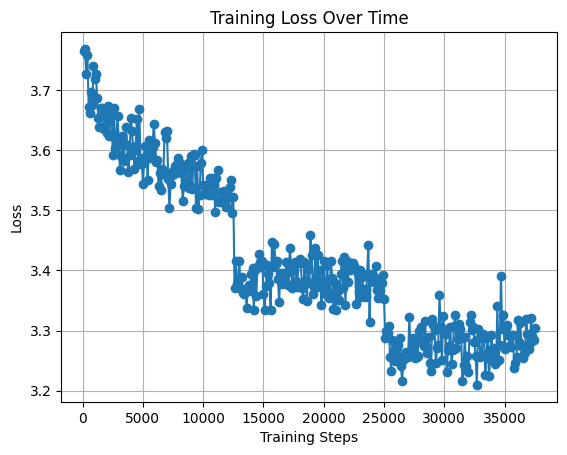

In [13]:
#####################################
# 5. Fine-Tuning with Training Graph Metrics
#####################################

from transformers import TrainerCallback  # Ensure TrainerCallback is imported

# Define training arguments. Adjust parameters (epochs, batch size, etc.) as needed.
training_args = TrainingArguments(
    output_dir="./model/gpt2-imdb-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_steps=500,
    # evaluation_strategy="steps",
    eval_strategy="steps",  # Updated argument name
    eval_steps=500,
    save_total_limit=2,
    logging_steps=100,
    prediction_loss_only=True,
    fp16=torch.cuda.is_available(),  # Use FP16 if available for faster training
    report_to="none",  # disable reporting integrations (e.g., wandb)
)

# Custom callback to log training steps and loss for plotting
class LogCallback(TrainerCallback):
    def __init__(self):
        self.logs = []
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            self.logs.append((state.global_step, logs["loss"]))

log_callback = LogCallback()

# (Optional) Re-load the base model for fine-tuning if not already loaded/modified
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Initialize the Trainer with the model, training arguments, datasets, data collator, and our logging callback
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    callbacks=[log_callback],
)

# Start fine-tuning
trainer.train()

# Save the final model and tokenizer
model.save_pretrained("./model/gpt2-imdb-finetuned")
tokenizer.save_pretrained("./model/gpt2-imdb-finetuned")

# Plot the training loss graph using the logged metrics
if log_callback.logs:
    steps, losses = zip(*log_callback.logs)
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(steps, losses, marker='o')
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.grid(True)
    plt.show()
else:
    print("No logs were recorded.")